## Titanic: Machine learning from disaster

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this tutorial, we will use passenger data to predict who survived the shipwreck and also use our predictive model to answer the question: "what sorts of people were more likely to survive?". We will focus on passenger age, gender and socio-economic class). You can read more about the Titanic dataset [here](https://www.kaggle.com/c/titanic/overview).

This is the advanced version of the tutorial, where we will learn how to build our own classifiers.
First, import packages and load the data.

In [1]:
import sys
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    filepath = "https://raw.githubusercontent.com/lm2612/Tutorials/refs/heads/main/2_supervised_learning_classification/titanic.csv"
    print(f"Notebook running in google colab. Using raw github filepath = {filepath}")

else:
    filepath = "../titanic.csv"
    print(f"Notebook running locally. Using local filepath = {filepath}")


Notebook running locally. Using local filepath = ../titanic.csv


In [3]:
df = pd.read_csv(filepath)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We are interested in the "Survived" column, where are two possible outcomes: survived (1) or did not survive (0). We want to build a classifier to predict this outcome. Specifically, we are going to investigate how the passenger class, age and sex influenced survival.

For passenger class, we are going to use dummy variables to represent the three possible states: binary variables which take on the value 0 if not true and 1 if true.

Create dummy variables for classes 1 and 2. This implicitly means that the 3rd class will be the base case that we compare to.

In [4]:
# Create new columns based on conditions
df['Class_1'] = np.where(df['Pclass'] == 1, 1, 0)
df['Class_2'] = np.where(df['Pclass'] == 2, 1, 0)

Create a dummy variable equal to 1 if the passenger was female.


In [5]:
df.loc[df['Sex']=='male', 'Sex'] = 0
df.loc[df['Sex']=='female', 'Sex'] = 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Class_1,Class_2
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0


Clean up the data - drop all variables except for 'Class_1', 'Class_2',  'Sex' and 'Age', for our inputs and  'Survived' for our outputs.

In [6]:
df = df[['Class_1', 'Class_2', 'Sex', 'Age', 'Survived']]
df = df.dropna()
df.head()

,Class_1,Class_2,Sex,Age,Survived
0,0,0,0,22.0,0
1,1,0,1,38.0,1
2,0,0,1,26.0,1
3,1,0,1,35.0,1
4,0,0,0,35.0,0


Split the data into training, validation and test data

In [7]:
# Split into ~60% training, 20% validation, 20% test
training = df.iloc[:109, :]
validation = df.iloc[109:145, :]
testing = df.iloc[145:, :]

Set up your X and y variables using the "Class_1" and "Class_2" variables.


In [8]:
X = training[['Class_1', 'Class_2']].values
y = training['Survived'].values

## Logistic Regression
Here we will create our own logistic regression classifier.


Write an R function for the logistic function: $\theta = \frac{1}{1 + \exp(-x)}$. The function takes \(x\) as its sole argument. Plot the function.


In [9]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

Text(0, 0.5, 'theta')

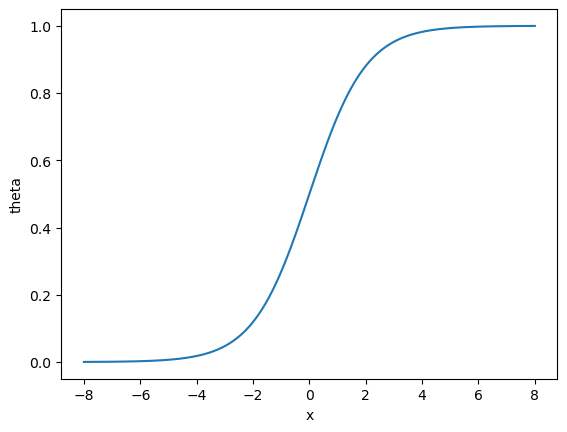

In [10]:
x = np.linspace(-8, 8, 1000)
theta = logistic(x)
plt.plot(x, theta)
plt.xlabel("x")
plt.ylabel("theta")

We are going to use the logistic function to represent the probability of a passenger surviving. But to do so, we need to write a function which returns the linear combination of $(\beta_0 + \beta_1 z_1 + \beta_2 z_2)$. The function should take as inputs $ ( \beta_0, \beta_1, \beta_2 )$ (the regression parameters) and the covariates $z_1$ and $z_2$.


In [11]:
def linear_combination(beta_0, beta_1, beta_2, z_1, z_2):
    return beta_0 + beta_1 * z_1 + beta_2 * z_2

Write a function which returns the probability:

$$\theta_i = Logistic(\beta_0 + \beta_1 * z_1 + \beta_2 * z_2) $$

where $Logistic$ is the function you created above. The function should takes as input $ ( \beta_0, \beta_1, \beta_2 )$ (the regression parameters) and the covariates $z_1$ and $z_2$.

In [12]:
def probability(beta_0, beta_1, beta_2, z_1, z_2):
    return logistic(linear_combination(beta_0, beta_1, beta_2, z_1, z_2))

We are now going to write a function which returns the log-likelihood for a single set, $i$ of data points: $(z_{1i}, z_{2i}, Si)$ where $S_i\in{0,1}$ represents whether a passenger survived (1) or not (0). In logistic regression, we assume that $S_i \sim Bernoulli(\theta_i)$. This means that the likelihood, $L_i$, for a single set of data points is given by:

$$ L_i = \theta_i^{S_i} (1-\theta_i)^{1-S_i} $$

Write a function with takes as input $ ( \beta_0, \beta_1, \beta_2 )$ (the regression parameters) and the covariates $z_1$ and $z_2$ and (crucially!) a value of $S_i$ and returns the likelihood $L_i$

.


In [13]:
def likelihood_i(S_i, beta_0, beta_1, beta_2, z_1, z_2):
    theta_i = probability(beta_0, beta_1, beta_2, z_1, z_2)
    return theta_i**S_i * (1 - theta_i)**(1 - S_i)


The overall likelihood of observations is given by the product of the individual likelihoods of each data point, since we assume that the data are (conditionally) independent given the parameters:

$$ L = \prod_i^{N} L_i $$

Write a function that takes as input your processed Titanic dataset and the parameters $\beta_0, \beta_1, \beta_2$ 
and returns the likelihood. In calculating the likelihood, specify that $z_1$ and $z_2$ should be your class dummies.

In [14]:
def likelihood(beta_0, beta_1, beta_2, df):
    val = 1
    for i in range(len(df)):
        row = df.iloc[i, :]
        val = val * likelihood_i(row["Survived"], beta_0, beta_1, beta_2,
                                 row["Class_1"], row["Class_2"])
    return val


We are now going to try to estimate the parameters $\beta_0$ and $\beta_1$ by doing a grid search. We start by fixing $\beta_0=-1.14$  (this is the maximum likelihood value of the parameter). We are then going to do a grid search across all combinations of the following values of  $\beta_1=(0,1,1.67,2,2.5)$ $\beta_2=(−1,0,1,2,3)$. For each of the 25 combinations of both sets of parameters, calculate the likelihood. In doing so, find parameters that are close to the maximum likelihood values.

In [15]:
beta_0 = -1.14
beta_1 = [0, 1, 1.67, 2, 2.5]
beta_2 = [-1, 0, 1, 2, 3]
likelihood_grid = np.zeros((len(beta_1), len(beta_2)))

for i in range(len(beta_1)):
    for j in range(len(beta_2)):
        likelihood_grid[i, j] = likelihood(beta_0, beta_1[i], beta_2[j], df)

        
likelihood_grid

array([[6.61131820e-254, 2.37123499e-230, 1.85180925e-220,
        1.54706613e-228, 5.56653906e-252],
       [4.84259923e-229, 1.73686100e-205, 1.35639668e-195,
        1.13318117e-203, 4.07732875e-227],
       [3.29162645e-223, 1.18058450e-199, 9.21974124e-190,
        7.70249389e-198, 2.77145444e-221],
       [1.69340124e-223, 6.07360311e-200, 4.74316314e-190,
        3.96260417e-198, 1.42579496e-221],
       [2.41039949e-227, 8.64521031e-204, 6.75145250e-194,
        5.64039926e-202, 2.02948679e-225]])

In [16]:
beta_0 = -1.14
beta_1 = [0, 1, 1.67, 2, 2.5]
beta_2 = [-1, 0, 1, 2, 3]
likelihood_grid = np.zeros((len(beta_1), len(beta_2)))

for i in range(len(beta_1)):
    for j in range(len(beta_2)):
        likelihood_grid[i, j] = likelihood(beta_0, beta_1[i], beta_2[j], df)

        
likelihood_grid

array([[6.61131820e-254, 2.37123499e-230, 1.85180925e-220,
        1.54706613e-228, 5.56653906e-252],
       [4.84259923e-229, 1.73686100e-205, 1.35639668e-195,
        1.13318117e-203, 4.07732875e-227],
       [3.29162645e-223, 1.18058450e-199, 9.21974124e-190,
        7.70249389e-198, 2.77145444e-221],
       [1.69340124e-223, 6.07360311e-200, 4.74316314e-190,
        3.96260417e-198, 1.42579496e-221],
       [2.41039949e-227, 8.64521031e-204, 6.75145250e-194,
        5.64039926e-202, 2.02948679e-225]])

Find the values of `beta_1` and `beta_2` in the grid with the maximum likelihood (note, if you are using `np.argmax`, the output index will be flattened, `np.unravel_index` may be helpful.)

In [17]:
likelihood_grid

array([[6.61131820e-254, 2.37123499e-230, 1.85180925e-220,
        1.54706613e-228, 5.56653906e-252],
       [4.84259923e-229, 1.73686100e-205, 1.35639668e-195,
        1.13318117e-203, 4.07732875e-227],
       [3.29162645e-223, 1.18058450e-199, 9.21974124e-190,
        7.70249389e-198, 2.77145444e-221],
       [1.69340124e-223, 6.07360311e-200, 4.74316314e-190,
        3.96260417e-198, 1.42579496e-221],
       [2.41039949e-227, 8.64521031e-204, 6.75145250e-194,
        5.64039926e-202, 2.02948679e-225]])

Text(0, 0.5, 'beta_2')

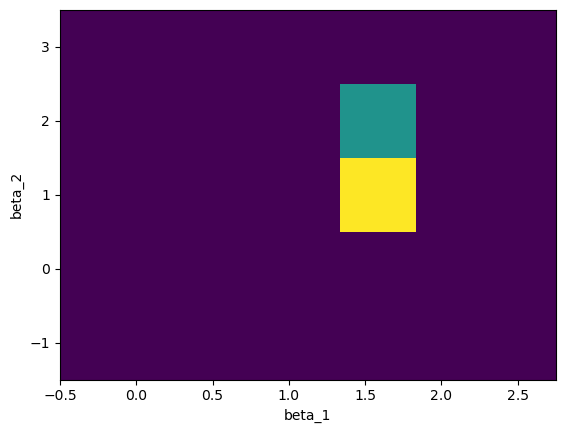

In [18]:
# First check how the likelihood looks as we traverse beta_1 and beta_2
plt.pcolormesh(beta_1, beta_2, likelihood_grid, shading="nearest")
plt.xlabel("beta_1")
plt.ylabel("beta_2")

In [19]:
max_likelihood_inds = np.unravel_index(np.argmax(likelihood_grid), likelihood_grid.shape)
max_likelihood_inds

(2, 2)

In [20]:
beta_1_mle = beta_1[max_likelihood_inds[1]]
beta_2_mle = beta_2[max_likelihood_inds[0]]
max_likelihood = likelihood_grid[max_likelihood_inds]
print(f"max likelihood {max_likelihood} when beta_1 = {beta_1_mle} and beta_2 = {beta_2_mle}")

max likelihood 9.21974123647161e-190 when beta_1 = 1.67 and beta_2 = 1


Compare your results to the what you would get with [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [21]:
import sklearn
from sklearn.linear_model import LogisticRegression

# Set up and fit the logistic regression model
reg = LogisticRegression(penalty=None)
reg.fit(df[['Class_1', 'Class_2']], df["Survived"])
reg.coef_

array([[1.80126317, 1.07487876]])

In [22]:
reg.intercept_

array([-1.15578838])

What do your estimates suggest are the odds ratios for survival relative to 3rd class passengers for being in 1st and 2nd classes respectively?



The odds ratios are given by the exponent of the estimates.

In [23]:
odds_ratio_class1 = np.exp(beta_1_mle)
odds_ratio_class2 = np.exp(beta_2_mle)
print(f"Odds ratio for class 1 to class 3: {odds_ratio_class1:.4f}. \
Odds ratio for class 2 to class 3: {odds_ratio_class2:.4f}.")

Odds ratio for class 1 to class 3: 5.3122. Odds ratio for class 2 to class 3: 2.7183.


What does your model predict is the change in probability of survival in moving from 3rd to 2nd class?


In [24]:
# 3rd class survival: class_1 = 0, class_2 = 0
survival_3 = probability(beta_0, beta_1_mle, beta_2_mle, 0, 0)
print(f"3rd class survival prob: {survival_3:.4f} ")

3rd class survival prob: 0.2423 


In [25]:
# 2nd class survival: class_1 = 0, class_2 = 1
survival_2 = probability(beta_0, beta_1_mle, beta_2_mle, 0, 1)
print(f"2nd class survival prob: {survival_2:.4f} ")

2nd class survival prob: 0.4651 


In [26]:
print(f"Change in survival prob: {survival_2 - survival_3:.4f}")

Change in survival prob: 0.2227


What is the change in probability in moving from 2nd to 1st class?


In [27]:
# 1st class survival: class_1 = 1, class_2 = 0
survival_1 = probability(beta_0, beta_1_mle, beta_2_mle, 1, 0)
print(f"1st class survival prob: {survival_1:.4f} ")

1st class survival prob: 0.6295 


In [28]:
print(f"Change in survival prob: {survival_1 - survival_2:.4f}")

Change in survival prob: 0.1644


## Decision Trees

We are going to build our own decision tree. We will use a five variables here. For age, we are going to split the data up into three segments: (i) those aged 16 or less; (ii) those between 16 and 60; (iii) and those over 60. Create dummy variables for categories (i) and (iii). 

In [29]:
df['Age_children'] = np.where(df['Age'] <= 16, 1, 0)
df['Age_old'] = np.where(df['Age'] > 60, 1, 0)
df = df[['Age_children', 'Age_old', 'Class_1', 'Class_2', 'Sex', 'Survived']]


The entropy of a binary outcome variable, $X_i$, is given by:

$$ H = p \log p + (1-p) \log (1-p) $$

where $ p = \Pr(X=1)$. 


Write a function which can calculate the entropy of a binary vector. Use it to calculate the entropy of the survival variable in the full dataset

In [30]:
# Function to calculate entropy
def entropy(v_binary):
    p = np.mean(v_binary == 1)
    
    if 0 < p < 1:
        return -p * math.log(p) - (1 - p) * math.log(1 - p)
    else:
        return 0


# Calculate total entropy
total_entropy = entropy(df['Survived'])
print(total_entropy)

0.6754313479380426


## Building a Decision Tree Classifier

We now start to build a decision tree classifier. To do so, we are going to choose one of the five variables to split on based on the reduction in entropy this provides. To do so, we calculate the conditional entropy, $H(X|V) $, where $V $

is a particular variable we have split on. At each step, we will choose the variable to split on so that it results in the greatest reduction in entropy.

### Conditional Entropy for a Binary Variable

The conditional entropy for a binary variable, $V$, is given by:

$$
H(X|V) = \frac{S(V=1)}{S(\varnothing)} \times H(S(V=1)) + \frac{S(V=0)}{S(\varnothing)} \times H(S(V=0)),
$$

where $S(V=v)$
is the set of members of the random variable $X $ corresponding to$V=v$. For example, consider:


In [31]:
df_example = pd.DataFrame({'X': [0, 1, 0, 1, 0, 1],
                           'V': [1, 1, 1, 0, 0, 1]})
df_example

,X,V
0,0,1
1,1,1
2,0,1
3,1,0
4,0,0
5,1,1


then $S(V=1)$ is the $X$ column from the subsetted data frame:

In [32]:
filtered_df = df_example[df_example['V'] == 1]
filtered_df

,X,V
0,0,1
1,1,1
2,0,1
5,1,1


Write a function to calculate the conditional entropy of splitting on a particular variable for your dataset.

In [33]:
def conditional_entropy(variable_name, df):
    # Group by the given variable_name and calculate entropy for each group
    df_subset_entropies = df.groupby(variable_name).agg(
        H=('Survived', lambda x: entropy(x)),
        n=('Survived', 'size')
    ).reset_index()

    # Calculate the probabilities (ps)
    total_n = df_subset_entropies['n'].sum()
    df_subset_entropies['p'] = df_subset_entropies['n'] / total_n

    # Return the weighted sum of entropy
    return (df_subset_entropies['p'] * df_subset_entropies['H']).sum()

In [34]:
df.columns

Index(['Age_children', 'Age_old', 'Class_1', 'Class_2', 'Sex', 'Survived'], dtype='object')

In [35]:
# Extract column names except the first one
vars = df.columns[:-1]  # All columns except 'survived'

# Calculate entropy reduction for each variable
Hs = []
for var in vars:
    Hs.append(conditional_entropy(var, df) - total_entropy)

# Create the result DataFrame
df_entropy_reduction = pd.DataFrame({
    'variable': vars,
    'entropy_reduction': Hs
})


In [36]:
df_entropy_reduction

,variable,entropy_reduction
0,Age_children,-0.006857
1,Age_old,-0.002269
2,Class_1,-0.045194
3,Class_2,-0.003556
4,Sex,-0.149731


Splitting on the female variable results in the greatest reduction in entropy.

Explain intuitively why splitting on that variable resulted in the greatest reduction in entropy?

To do this, consider the balance between the survival classes after splitting on each of the variables.

In [37]:
df.groupby('Age_children').agg(
    n=('Survived', 'size'),  # Count the number of occurrences (n)
    p=('Survived', 'mean')   # Calculate the mean of 'survived' (p)
)

,n,p
Age_children,,
0,614,0.382736
1,100,0.550000


In [38]:
df.groupby('Age_old').agg(
    n=('Survived', 'size'),  # Count the number of occurrences (n)
    p=('Survived', 'mean')   # Calculate the mean of 'survived' (p)
)

,n,p
Age_old,,
0,692,0.411850
1,22,0.227273


In [42]:
df.groupby('Class_1').agg(
    n=('Survived', 'size'),  # Count the number of occurrences (n)
    p=('Survived', 'mean')   # Calculate the mean of 'survived' (p)
)

,n,p
Class_1,,
0,528,0.318182
1,186,0.655914


In [43]:
df.groupby('Class_2').agg(
    n=('Survived', 'size'),  # Count the number of occurrences (n)
    p=('Survived', 'mean')   # Calculate the mean of 'survived' (p)
)

,n,p
Class_2,,
0,541,0.382625
1,173,0.479769


In [44]:
df.groupby('Sex').agg(
    n=('Survived', 'size'),  # Count the number of occurrences (n)
    p=('Survived', 'mean')   # Calculate the mean of 'survived' (p)
)

,n,p
Sex,,
0,453,0.205298
1,261,0.754789


Splitting on female results in two large groups which are fairly homogeneous in terms of survival vs the other splits.

Create a decision tree classifier using the variable you have identified. The classifier outputs a classification probability:
$$ \Pr (X=1|V=v)=\frac{1}{S(V=v)}\sum_{i\in S(V=v)} X_i $$

where $X$ denotes the survival variable and $V$ denotes the variable you split on. The above just means your outputted probability of survival is the corresponding fraction surviving in the subset corresponding to that particular value of the variable $V$.

In [49]:
# Define the depth_one_classifier function in Python
def depth_one_classifier(female_val, df):
    # Group by 'female' and calculate the mean survival probability
    grouped = df.groupby('Sex')['Survived'].mean().reset_index()
    
    # Filter the rows where 'female' matches 'female_val' and get the 'survived' probability
    result = grouped[grouped['Sex'] == female_val]['Survived'].values[0]
    
    return result


In [52]:
male_survival_prob = depth_one_classifier(0, df)
female_survival_prob = depth_one_classifier(1, df)

print(f"Male survival prob: {male_survival_prob:.4f}. Female survival prob: {female_survival_prob:.4f}")

Male survival prob: 0.2053. Female survival prob: 0.7548


Create a decision tree classifier with depth 2 (i.e. it splits on two variables), where in each step it chooses which variable to split on based on the greatest reduction in entropy.

After splitting on female, we are left with two dataframes:

In [57]:
df_f = df[df['Sex'] == 1]   # Female
df_m = df[df['Sex'] == 0]   # Male

Which have associated with them the following entropies for the survival variable.

In [58]:
## female
total_entropy_f = entropy(df_f['Survived'])
total_entropy_f

0.5570121625088897

In [60]:
## male
total_entropy_m = entropy(df_m['Survived'])
total_entropy_m

0.5076598866633676

We now consider splitting on another of the remaining variables.

In [63]:
# Get the column names excluding the first one and excluding 'Sex'
vars = [col for col in df.columns[:-1] if col != 'Sex']

# Calculate entropy reduction for females
Hs_f = []
for var in vars:
    Hs_f.append(conditional_entropy(var, df_f) - total_entropy_f)

# Create a DataFrame for female entropy reduction
df_entropy_reduction_f = pd.DataFrame({
    'variable': vars,
    'entropy_reduction': Hs_f,
    'sex': 'female'
})

# Calculate entropy reduction for males
Hs_m = []
for var in vars:
    Hs_m.append(conditional_entropy(var, df_m) - total_entropy_m)

# Create a DataFrame for male entropy reduction
df_entropy_reduction_m = pd.DataFrame({
    'variable': vars,
    'entropy_reduction': Hs_m,
    'sex': 'male'
})

# Combine the DataFrames for both sexes
df_both_sexes = pd.concat([df_entropy_reduction_f, df_entropy_reduction_m])

# Group by 'variable' and summarize the entropy reduction
df_summary = df_both_sexes.groupby('variable').agg(
    entropy_reduction=('entropy_reduction', 'sum')
).reset_index()

# Display the summarized result
print(df_summary)

       variable  entropy_reduction
0  Age_children          -0.020885
1       Age_old          -0.004811
2       Class_1          -0.100878
3       Class_2          -0.036182


So, we next split on the class_1 variable.

In [68]:
def depth_two_classifier(female_val, class_1_val, df):
    # Group by 'female' and 'class_1' and calculate the mean of 'survived'
    grouped = df.groupby(['Sex', 'Class_1'])['Survived'].mean().reset_index()
    
    # Filter based on female_val and class_1_val
    result = grouped[(grouped['Sex'] == female_val) & (grouped['Class_1'] == class_1_val)]['Survived'].values[0]
    
    return result


Use your classifier to output the probabilities of survival for each (type of) individual in your dataset. Which groups have the highest survival probabilities and the lowest survival probabilities?


In [70]:
# female and 1st class
depth_two_classifier(female_val=1, class_1_val=1, df=df)

0.9647058823529412

In [72]:
# female and other class
depth_two_classifier(female_val=1, class_1_val=0, df=df)

0.6534090909090909

In [75]:
# male and 1st class
depth_two_classifier(female_val=0, class_1_val=1, df=df)

0.39603960396039606

In [76]:
# male and other class
depth_two_classifier(female_val=0, class_1_val=0, df=df)

0.15056818181818182

Oh dear; being male and from another class results in a low chance of survival whereas female and 1st class is a high chance.